## Project 1, tornadoes and mobile home parks in the US, risk analysis.

In [70]:

# import dependencies

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from folium import Map
import math
import webbrowser
from uszipcode import SearchEngine

In [2]:
# define paths for both files

tornadoes_data_path = "1950-2021_all_tornadoes.csv"
mobile_home_parks_path = "Mobile_Home_Parks.csv"

# Read the data from both csv's 

tornadoes_data = pd.read_csv(tornadoes_data_path)
mobile_home_data = pd.read_csv(mobile_home_parks_path)

display(tornadoes_data)
display(mobile_home_data) 


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,15.80,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2.00,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0.10,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0.10,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2.00,37,1,1,1,101,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68863,620523,2021,9,8,2021-09-08,15:32:00,3,PA,42,0,...,0.73,30,1,1,1,109,0,0,0,0
68864,620524,2021,9,8,2021-09-08,15:35:00,3,PA,42,0,...,1.45,30,1,1,1,109,0,0,0,0
68865,620525,2021,9,8,2021-09-08,19:08:00,3,FL,12,0,...,1.45,50,1,1,1,129,0,0,0,0
68866,620526,2021,9,9,2021-09-09,02:10:00,3,CT,9,0,...,0.75,75,1,1,1,13,0,0,0,0


,index,X,Y,FID,MHPID,NAME,ADDRESS,ADDRESS2,CITY,STATE,...,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,UNITS,SIZE,YEARBLT,RevGeoFlag
0,0,-81.687714,28.852114,2001,2101,Sharp's Mobile Park,43 Sharp Circle,Not Available,Eustis,FL,...,Residential trailer parks,Open,1900-01-01T00:00:00.000Z,Both Internet and Imagery,2013-03-04T00:00:00.000Z,Not Available,0,Not Available,,No
1,1,-85.232052,30.771086,2002,2001,Stage Creek Trailer Park,4366 Pearl Street,Not Available,Marianna,FL,...,Residential trailer parks,Open,1900-01-01T00:00:00.000Z,Imagery or Map Only,2013-03-01T00:00:00.000Z,Not Available,0,Not Available,,No
2,2,-85.163627,30.789739,2003,2002,Springside Estates,5164 Copper Lane,Not Available,Marianna,FL,...,Residential trailer parks,Open,1900-01-01T00:00:00.000Z,Imagery or Map Only,2013-03-01T00:00:00.000Z,Not Available,0,Not Available,,No
3,3,-81.687733,28.815828,2004,2102,Lake Saunders Mobile Home Park,4301 Hwy 19A,Not Available,Mount Dora,FL,...,Mobile (manufactured) home parks,Open,1900-01-01T00:00:00.000Z,Imagery or Map Only,2013-03-06T00:00:00.000Z,Not Available,0,Not Available,,No
4,4,-81.784127,28.529614,2005,2103,Jones Cypress Cove Resort,10233 Cypress Cove Lane,Not Available,Clermont,FL,...,Mobile (manufactured) home parks,Open,1900-01-01T00:00:00.000Z,Imagery or Map Only,2013-03-06T00:00:00.000Z,Not Available,0,Not Available,,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38524,38524,-92.391481,34.884523,38525,41433,Not Available,14121 Overstreet Rd,Not Available,Maumelle,AR,...,Residential trailer parks,Imagery,2015-01-30T00:00:00.000Z,Both Internet and Imagery,2015-01-30T00:00:00.000Z,Not Available,0,S,,No
38525,38525,-84.350860,40.832630,38526,41219,Not Available,826 Skinner St,Not Available,Delphos,OH,...,Residential trailer parks,Imagery,2015-01-23T00:00:00.000Z,Both Internet and Imagery,2015-01-23T00:00:00.000Z,Not Available,0,M,,No
38526,38526,-83.823340,40.754216,38527,41220,Not Available,4525 State Route 235,Not Available,Ada,OH,...,Recreational vehicle parks,Imagery,2015-01-23T00:00:00.000Z,Both Internet and Imagery,2015-01-23T00:00:00.000Z,Not Available,0,M,,No
38527,38527,-83.815211,40.769507,38528,41221,Not Available,547 E Lincoln Ave,Not Available,Ada,OH,...,Residential trailer parks,Imagery,2015-01-23T00:00:00.000Z,Both Internet and Imagery,2015-01-23T00:00:00.000Z,Not Available,0,M,,No


In [3]:
# CLEANING DATA FOR BOTH CSV FILES
# Rename columns in tornadoes_data
clean_tornadoes_data = tornadoes_data.rename(columns={
    "yr": "year",
    "mo": "month",
    "dy": "day",
    "st": "state",
    "mag": "magnitude",
    "inj": "injuries",
    "fat": "fatalities",
    "loss": "propertyloss",
    "closs": "lossinmillions",
    "slat": "latitude",
    "slon": "longitude",
    "elat": "latitudeend",
    "elon": "longitudeend",
    "len": "lengthinmiles",
    "wid": "widthinyards",
    })
# Delete columns in tornadoes_data
clean_tornadoes_data = clean_tornadoes_data.drop(columns={"om","tz","stf","stn","ns","sn","sg","f1","f2","f3","f4","fc"})
clean_tornadoes_data = clean_tornadoes_data[(clean_tornadoes_data['latitude'] != 0) | (clean_tornadoes_data['longitude'] != 0)]
clean_tornadoes_data['latitude'] = clean_tornadoes_data['latitude'].round(1)
clean_tornadoes_data['longitude'] = clean_tornadoes_data['longitude'].round(1)
display(clean_tornadoes_data)

# Rename columns in mobile_home_data
clean_mobile_home_data = mobile_home_data.rename(columns={
    "NAME": "name",
    "ADDRESS": "address",
    "CITY": "city",
    "STATE": "state",
    "ZIP": "zipcode",
    "TELEPHONE": "telephone",
    "TYPE": "type",
    "STATUS": "status",
    "COUNTY": "county",
    "LATITUDE": "latitude",
    "LONGITUDE": "longitude"
    })
# Delete columns in mobile home parks data
clean_mobile_home_data = clean_mobile_home_data.drop(columns={
"X", "Y", "FID", "MHPID", "ADDRESS2", "ZIP4", "COUNTYFIPS",
"COUNTRY", "NAICS_CODE", "NAICS_DESC", "SOURCE",
"SOURCEDATE", "VAL_METHOD", "VAL_DATE", "WEBSITE","index",
"UNITS", "SIZE", "YEARBLT", "RevGeoFlag"})
clean_mobile_home_data = clean_mobile_home_data[(clean_mobile_home_data['latitude'] != 0) | (clean_mobile_home_data['longitude'] != 0)]
# Round coordinates to 4 decimal places
clean_mobile_home_data['latitude'] = clean_mobile_home_data['latitude'].round(1)
clean_mobile_home_data['longitude'] = clean_mobile_home_data['longitude'].round(1)
display(clean_mobile_home_data)

,year,month,day,date,time,state,magnitude,injuries,fatalities,propertyloss,lossinmillions,latitude,longitude,latitudeend,longitudeend,lengthinmiles,widthinyards
0,1950,10,1,1950-10-01,21:00:00,OK,1,0,0,4.0,0.0,36.7,-102.5,36.8800,-102.3000,15.80,10
1,1950,10,9,1950-10-09,02:15:00,NC,3,3,0,5.0,0.0,34.2,-78.6,0.0000,0.0000,2.00,880
2,1950,11,20,1950-11-20,02:20:00,KY,2,0,0,5.0,0.0,37.4,-87.2,0.0000,0.0000,0.10,10
3,1950,11,20,1950-11-20,04:00:00,KY,1,0,0,5.0,0.0,38.2,-84.5,0.0000,0.0000,0.10,10
4,1950,11,20,1950-11-20,07:30:00,MS,1,3,0,4.0,0.0,32.4,-89.1,0.0000,0.0000,2.00,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68863,2021,9,8,2021-09-08,15:32:00,PA,1,0,0,0.0,0.0,40.8,-77.0,40.7507,-76.9959,0.73,30
68864,2021,9,8,2021-09-08,15:35:00,PA,0,0,0,20000.0,0.0,40.8,-76.9,40.7561,-76.8878,1.45,30
68865,2021,9,8,2021-09-08,19:08:00,FL,0,0,0,0.0,0.0,30.2,-84.4,30.1775,-84.4629,1.45,50
68866,2021,9,9,2021-09-09,02:10:00,CT,0,0,0,40000.0,0.0,41.8,-72.3,41.7570,-72.2880,0.75,75


,name,address,city,state,zipcode,telephone,type,status,county,latitude,longitude
0,Sharp's Mobile Park,43 Sharp Circle,Eustis,FL,32726,352-357-5254,Mobile Home Park,Open,Lake,28.9,-81.7
1,Stage Creek Trailer Park,4366 Pearl Street,Marianna,FL,32446,850-638-8570,Mobile Home Park,Open,Jackson,30.8,-85.2
2,Springside Estates,5164 Copper Lane,Marianna,FL,32446,252-241-8399,Mobile Home Park,Open,Jackson,30.8,-85.2
3,Lake Saunders Mobile Home Park,4301 Hwy 19A,Mount Dora,FL,32757,407-704-2136,Mobile Home Park,Open,Lake,28.8,-81.7
4,Jones Cypress Cove Resort,10233 Cypress Cove Lane,Clermont,FL,34711,352-394-7900,Mobile Home Park,Open,Lake,28.5,-81.8
...,...,...,...,...,...,...,...,...,...,...,...
38524,Not Available,14121 Overstreet Rd,Maumelle,AR,72113,Not Available,Mobile Home Park,Unknown,Pulaski,34.9,-92.4
38525,Not Available,826 Skinner St,Delphos,OH,45833,Not Available,Mobile Home Park,Unknown,Van Wert,40.8,-84.4
38526,Not Available,4525 State Route 235,Ada,OH,45810,Not Available,MHP/RV/Migrant Housing,Unknown,Hardin,40.8,-83.8
38527,Not Available,547 E Lincoln Ave,Ada,OH,45810,Not Available,Mobile Home Park,Unknown,Hardin,40.8,-83.8


In [4]:
#MERGING THE DATA
#setting display options to preview all columns
#MERGING THE DATA
#setting display options to preview all columns
pd.set_option('display.max_columns', None)
tornado_mobiles_merge=pd.merge(clean_tornadoes_data, clean_mobile_home_data, left_on=["longitude","latitude"],right_on=["longitude","latitude"])
merge_data_df = pd.DataFrame(tornado_mobiles_merge)
# Export the tornado_mobiles_merge data into a csv
merge_data_df.to_csv("../Project1Bootcamp/tornadoesandparksmerged.csv")
merge_data_df

,year,month,day,date,time,state_x,magnitude,injuries,fatalities,propertyloss,lossinmillions,latitude,longitude,latitudeend,longitudeend,lengthinmiles,widthinyards,name,address,city,state_y,zipcode,telephone,type,status,county
0,1950,11,20,1950-11-20,04:00:00,KY,1,0,0,5.0,0.0,38.2,-84.5,0.0000,0.0000,0.10,10,Spindletop Village,101 Dale Drive,Georgetown,KY,40324,502-863-5656,Mobile Home Park,Open,Scott
1,1950,11,20,1950-11-20,04:00:00,KY,1,0,0,5.0,0.0,38.2,-84.5,0.0000,0.0000,0.10,10,Not Available,1175 Lisle Rd,Georgetown,KY,40324,Not Available,Mobile Home Park,Open,Scott
2,1950,11,20,1950-11-20,04:00:00,KY,1,0,0,5.0,0.0,38.2,-84.5,0.0000,0.0000,0.10,10,Not Available,4812 Georgetown Rd,Lexington,KY,40511,Not Available,Mobile Home Park,Open,Fayette
3,1950,11,20,1950-11-20,04:00:00,KY,1,0,0,5.0,0.0,38.2,-84.5,0.0000,0.0000,0.10,10,Not Available,1250 Paris Pike,Georgetown,KY,40324,Not Available,Mobile Home Park,Open,Scott
4,1977,10,1,1977-10-01,08:00:00,KY,1,0,0,5.0,0.0,38.2,-84.5,38.1200,-84.3800,9.20,400,Spindletop Village,101 Dale Drive,Georgetown,KY,40324,502-863-5656,Mobile Home Park,Open,Scott
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104568,2021,9,1,2021-09-01,14:15:00,PA,2,0,0,500000.0,0.0,39.8,-76.0,39.8500,-75.9300,5.92,350,Not Available,16 Circle Dr,Nottingham,PA,19362,Not Available,Mobile Home Park,Open,Chester
104569,2021,9,7,2021-09-07,17:45:00,MI,1,0,0,0.0,0.0,41.9,-84.7,41.8929,-84.5897,5.33,450,Hillside Acres MHP,5200 Bankers Road,Reading,MI,49274,517-283-2844,Mobile Home Park,Open,Hillsdale
104570,2021,9,7,2021-09-07,17:45:00,MI,1,0,0,0.0,0.0,41.9,-84.7,41.8929,-84.5897,5.33,450,Not Available,2722 W Card Rd,Hillsdale,MI,49242,Not Available,Mobile Home Park,Unknown,Hillsdale
104571,2021,9,9,2021-09-09,02:10:00,CT,0,0,0,40000.0,0.0,41.8,-72.3,41.7570,-72.2880,0.75,75,Not Available,541 Middle Tpke,Mansfield Town Of,CT,6268,Not Available,Mobile Home Park,Open,Tolland


"Analisis de frecuencia e intensidad de tornados

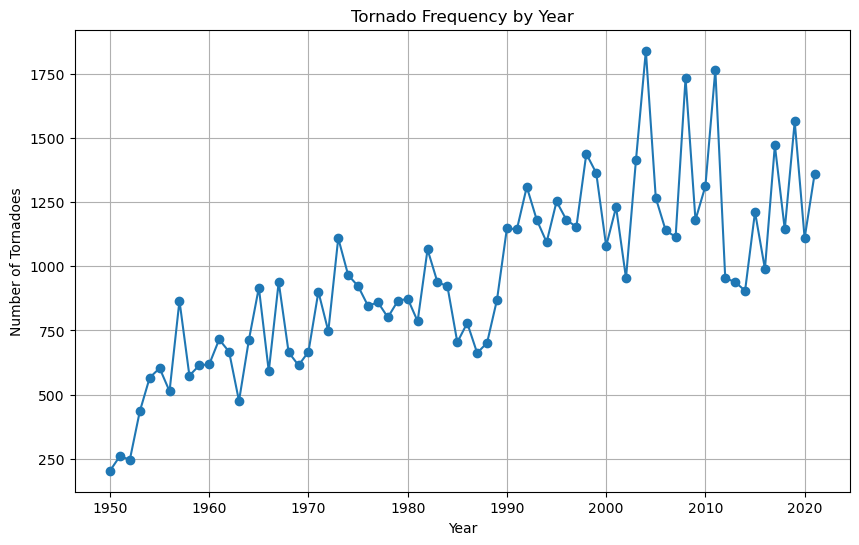

In [5]:

# Convert the 'year' column to date format
clean_tornadoes_data['year'] = pd.to_datetime(clean_tornadoes_data['year'], format='%Y')

# Group the data by year and count the number of tornadoes in each year
tornadoes_by_year = clean_tornadoes_data.groupby(clean_tornadoes_data['year'].dt.year).size()

# Visualize the tornado frequency over time
plt.figure(figsize=(10, 6))
plt.plot(tornadoes_by_year.index, tornadoes_by_year.values, marker='o', linestyle='-')
plt.title('Tornado Frequency by Year')
plt.xlabel('Year')
plt.ylabel('Number of Tornadoes')
plt.grid(True)
plt.show()


C:\Users\pablo\AppData\Local\Temp\ipykernel_15316\1781499788.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, val + 5, f'{percentage[i]:.2f}%', ha='center')


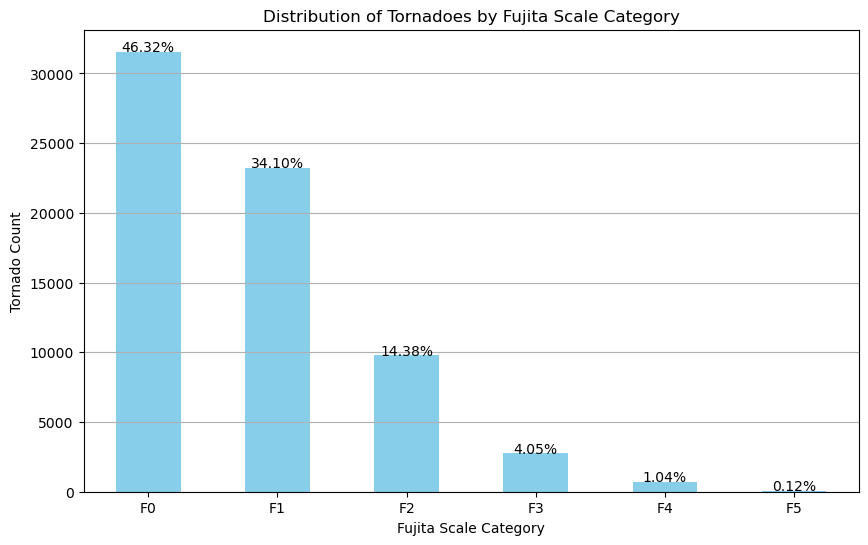

In [6]:
# Define a dictionary to map magnitudes to Fujita scale categories
fujita_scale_map = {0: 'F0', 1: 'F1', 2: 'F2', 3: 'F3', 4: 'F4', 5: 'F5'}

# Apply the mapping to create the 'fujita_scale_category' column
clean_tornadoes_data['fujita_scale_category'] = clean_tornadoes_data['magnitude'].map(fujita_scale_map)

# Calculate the distribution of the Fujita scale category
fujita_scale_distribution = clean_tornadoes_data['fujita_scale_category'].value_counts()

# Calculate the percentage of each category
percentage = (fujita_scale_distribution / fujita_scale_distribution.sum()) * 100

# Plot a bar chart to show the distribution of the Fujita scale category
plt.figure(figsize=(10, 6))
bars = fujita_scale_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Tornadoes by Fujita Scale Category')
plt.xlabel('Fujita Scale Category')
plt.ylabel('Tornado Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add grid lines to the y-axis

# Annotate bars with percentage values
for i, val in enumerate(fujita_scale_distribution):
    plt.text(i, val + 5, f'{percentage[i]:.2f}%', ha='center')

plt.show()


##Distribución geográfica de los tornados

Top 10 Estados más afectados por tornados:
state
TX    9204
KS    4438
OK    4175
FL    3507
NE    3000
IA    2812
IL    2739
MS    2532
MO    2504
AL    2434
Name: count, dtype: int64


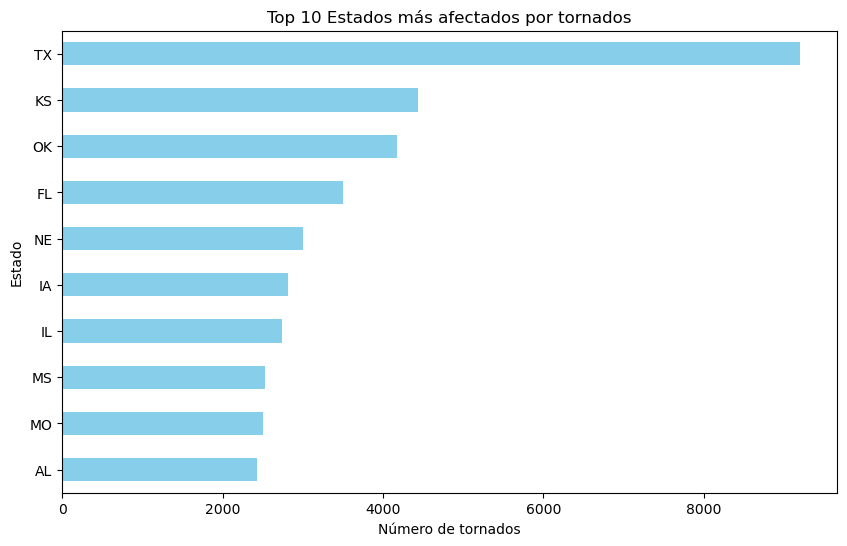

In [8]:
# Count occurrences of tornadoes by state and sort from highest to lowest
tornado_count_by_state = clean_tornadoes_data["state"].value_counts().sort_values(ascending=False)

#Print the sorted tornado counts by state
#print(tornado_count_by_state)


# Visualizar los estados más afectados por los tornados (top 10)
top_affected_states = tornado_count_by_state.head(10)
print("Top 10 Estados más afectados por tornados:")
print(top_affected_states)

# Visualizar los estados más afectados por los tornados (top 10) en un gráfico de barras horizontal
plt.figure(figsize=(10, 6))
tornado_count_by_state.head(10).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Estados más afectados por tornados')
plt.xlabel('Número de tornados')
plt.ylabel('Estado')
plt.show()



In [ ]:

# Agrupa los tornados por estado y escala Fujita, y cuenta el número de tornados en cada categoría
#grouped_data = clean_tornadoes_data.groupby(['state_x', 'fujita_scale_category']).size().unstack(fill_value=0)

# Calcula el porcentaje de cada categoría para cada estado
#percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Traza un gráfico de barras para cada estado mostrando la distribución de la escala Fujita
#fig, axes = plt.subplots(nrows=len(grouped_data.index), figsize=(10, 6 * len(grouped_data.index)))

#for i, (state, data) in enumerate(grouped_data.iterrows()):
    # ax = data.plot(kind='bar', ax=axes[i], color='skyblue')
    # ax.set_title(f'Distribution of Tornadoes by Fujita Scale in {state}')
    # ax.set_xlabel('Fujita Scale Category')
    # ax.set_ylabel('Tornado Count')
    # ax.set_xticklabels(data.index, rotation=0)
    # ax.grid(axis='y')

    # Anota las barras con los porcentajes
    #for j, val in enumerate(data):
        #ax.text(j, val + 2, f'{percentage.loc[state][j]:.2f}%', ha='center')

#plt.tight_layout()
#plt.show()

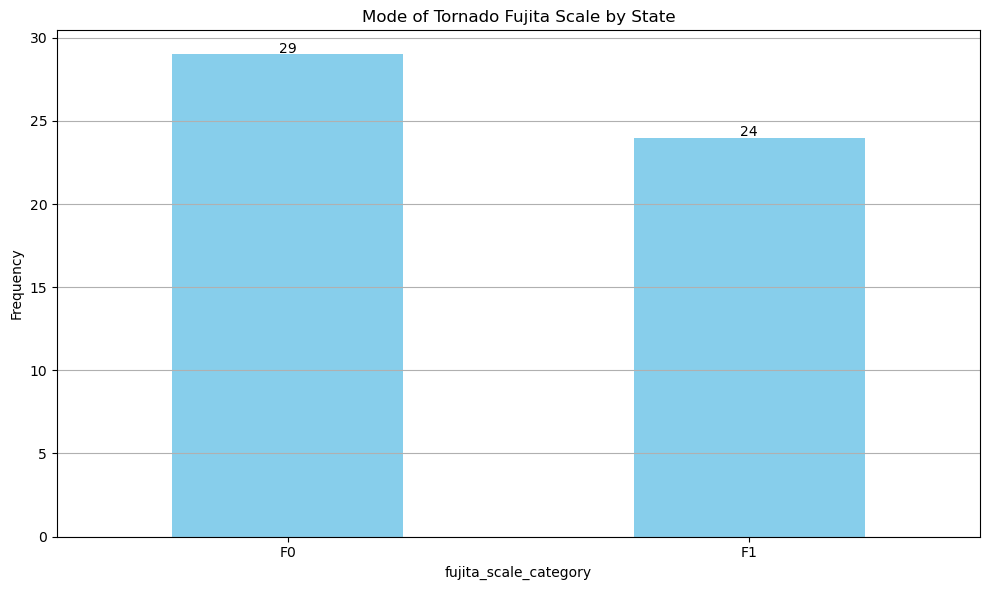

In [10]:
# Calcula el modo de la escala Fujita por estado
mode_fujita_scale = clean_tornadoes_data.groupby('state')['fujita_scale_category'].apply(lambda x: x.mode()[0])

# Traza un gráfico de barras para mostrar el modo de la escala Fujita por estado
plt.figure(figsize=(10, 6))
mode_fujita_scale.value_counts().plot(kind='bar', color='skyblue')
plt.title('Mode of Tornado Fujita Scale by State')
plt.xlabel('fujita_scale_category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Anota las barras con los valores del modo
for i, val in enumerate(mode_fujita_scale.value_counts()):
    plt.text(i, val + 0.1, f'{val}', ha='center')

plt.tight_layout()
plt.show()

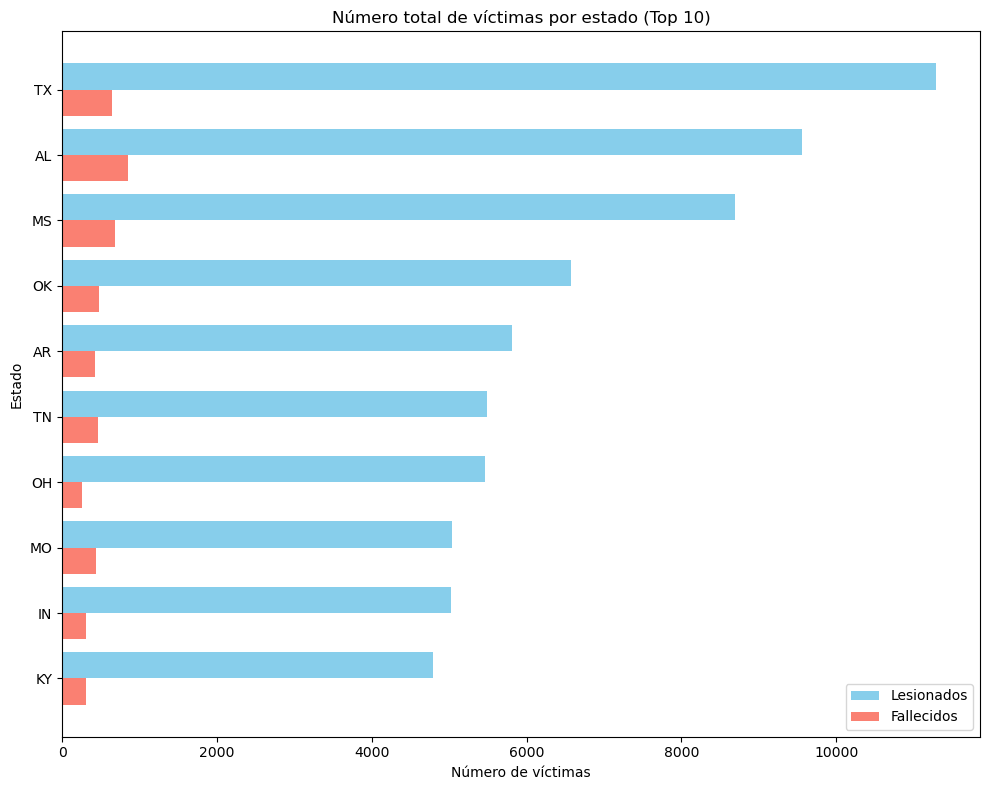

In [11]:
import numpy as np
# Número total de víctimas (lesionados y fallecidos) por estado
tornado_victims_by_state = clean_tornadoes_data.groupby('state')[['injuries', 'fatalities']].sum()

# Seleccionar los diez estados con el mayor número total de víctimas
top_10_states = tornado_victims_by_state.sum(axis=1).nlargest(10).index
tornado_victims_top_10 = tornado_victims_by_state.loc[top_10_states]

# Visualizar el número total de víctimas (lesionados y fallecidos) por estado en un gráfico de barras horizontales
plt.figure(figsize=(10, 8))
bar_width = 0.4
index = np.arange(len(tornado_victims_top_10))
plt.barh(index, tornado_victims_top_10['injuries'], bar_width, label='Lesionados', color='skyblue')
plt.barh(index + bar_width, tornado_victims_top_10['fatalities'], bar_width, label='Fallecidos', color='salmon')
plt.xlabel('Número de víctimas')
plt.ylabel('Estado')
plt.title('Número total de víctimas por estado (Top 10)')
plt.yticks(index + bar_width / 2, tornado_victims_top_10.index)
plt.legend()
plt.gca().invert_yaxis()  # Invertir el eje y para que los estados aparezcan en orden descendente
plt.tight_layout()
plt.show()

In [72]:
# Step 1: Calculate Tornado Count by Location
tornado_count_by_location = merge_data_df.groupby(['latitude', 'longitude']).size().reset_index(name='tornado_count')
tornado_count_by_location['yearly_average'] = tornado_count_by_location['tornado_count'] / 71
# Step 2: Calculate Tornado Count by State
try:
    search = SearchEngine(simple_zipcode=True)
except Exception as e:
    print("An error occurred while initializing the SearchEngine:", e)
    # Handle the error here, such as logging or displaying an error message to the user

merge_data_df['state'] = merge_data_df['zip_code'].apply(lambda x: search.by_zipcode(x).state)

tornado_count_by_state = merge_data_df.groupby('state').size().reset_index(name='tornado_count')
tornado_count_by_state['yearly_average'] = tornado_count_by_state['tornado_count'] / 71

# Convert yearly average to risk level
def classify_risk(yearly_average):
    risk_levels = {
        'Low': (0, 0.1),
        'Moderate': (0.1, 0.3),
        'High': (0.3, 0.6),
        'Very High': (0.6, 1)
    }
    for level, (lower, upper) in risk_levels.items():
        if lower <= yearly_average < upper:
            return level
    return np.nan  # Set NaN for unknown levels

tornado_count_by_state['risk_level'] = tornado_count_by_state['yearly_average'].apply(classify_risk)

# Remove NaN values from tornado count data
tornado_count_by_state.dropna(subset=['risk_level'], inplace=True)

# Map risk levels to numerical values
risk_mapping = {
    'Low': 0.05,
    'Moderate': 0.2,
    'High': 0.45,
    'Very High': 0.8
}

# Convert Pandas DataFrame to a list of lists for state data
tornado_data_state = tornado_count_by_state[['state', 'risk_level']].values.tolist()

# Filter out rows with NaN risk levels and map risk levels to numerical values
tornado_data_state = [[state, risk_mapping[risk]] for state, risk in tornado_data_state if risk in risk_mapping]

# Debugging
print("After filtering (by state):")
for state, risk in tornado_data_state:
    print(f"State: {state}, Risk: {risk}")

# Create a map centered on the USA
map_usa = Map(location=[37.0902, -95.7129], zoom_start=4)

# Add HeatMap layer for state data
HeatMap(tornado_data_state, gradient={0.05: 'green', 0.2: 'yellow', 0.45: 'orange', 0.8: 'red'}).add_to(map_usa)

# Save the map to an HTML file
map_usa.save('tornado_risk_level_heatmap_by_state.html')

# Open the HTML file in a web browser
webbrowser.open('tornado_risk_level_heatmap_by_state.html')

Exception ignored in: <function SearchEngine.__del__ at 0x0000024992000CA0>
Traceback (most recent call last):
  File "c:\Users\pablo\anaconda3\envs\dev\lib\site-packages\uszipcode\search.py", line 195, in __del__
    if self.ses:
AttributeError: 'SearchEngine' object has no attribute 'ses'


An error occurred while initializing the SearchEngine: SearchEngine.__init__() got an unexpected keyword argument 'simple_zipcode'


KeyError: 'zip_code'